## General Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cm
from salishsea_tools import viz_tools
import matplotlib as mpl
import pandas as pd
import netCDF4 as nc
import shapely.geometry
from shapely.geometry import box
from shapely.ops import unary_union
# from datetime import datetime
# from matplotlib.dates import DateFormatter
# import matplotlib.colors as colors
import gsw

In [2]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]
area = ((1-tmask) * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth', 'y':'gridY', 'x':'gridX'})[0]
volume = ((1-tmask) * mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth', 'y':'gridY', 'x':'gridX'})
max_depth = bathy.Bathymetry.rename({'y':'gridY', 'x':'gridX'})
mean_depth = np.nanmean(max_depth.to_numpy())

In [3]:
thalweg_file = '/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/admiralty_thalweg.txt'
thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)

In [4]:
y_thal_ad = thalweg_pts[:,0]
x_thal_ad = thalweg_pts[:,1]

In [5]:
y_thal_ad

array([220, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209,
       208, 207, 206, 205, 204, 203, 202, 201, 200, 199, 198, 197, 196,
       195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183,
       182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170,
       169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157,
       156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144,
       143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131,
       130, 129, 128, 127, 126, 125])

In [6]:
# dimensions: gridY, gridX, time
vol_2023_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2023, 2023))
vol_2022_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2022, 2022))
vol_2021_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2021, 2021))
vol_2020_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2020, 2020))
vol_2019_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2019, 2019))

In [7]:
phys_2023_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allP_00_40_res1M_{}0101_{}1231.nc'.format(2023, 2023))
phys_2022_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allP_00_40_res1M_{}0101_{}1231.nc'.format(2022, 2022))
phys_2021_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allP_00_40_res1M_{}0101_{}1231.nc'.format(2021, 2021))
phys_2020_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allP_00_40_res1M_{}0101_{}1231.nc'.format(2020, 2020))
phys_2019_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allP_00_40_res1M_{}0101_{}1231.nc'.format(2019, 2019))

## Functions

In [8]:
tablist_nogrey = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan', 'darkgrey']

## Cross-sections

In [9]:
def y_mxb(m, x, b):
    y = m * x + b
    return y

In [10]:
def create_transect(x1, x2, y1, y2):
    m = (y2- y1)/(x2-x1)
    x_all = np.arange(x1, x2+1)
    y_all = y_mxb(m, x_all, y1)
    x_grid = np.floor(x_all).astype(int)
    y_grid = np.floor(y_all).astype(int)
    return x_grid, y_grid


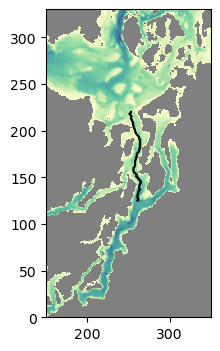

In [11]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
mycmap = cm.deep
mycmap.set_bad('grey')

ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax.set_xlim(150,350)
ax.set_ylim(0,330)
viz_tools.set_aspect(ax);
ax.plot(x_thal_ad, y_thal_ad, color='k')

In [12]:
phys_2023_thal_ad = phys_2023_mon.sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad)).mean(dim='time')
phys_2022_thal_ad = phys_2022_mon.sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad)).mean(dim='time')
phys_2021_thal_ad = phys_2021_mon.sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad)).mean(dim='time')
phys_2020_thal_ad = phys_2020_mon.sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad)).mean(dim='time')
phys_2019_thal_ad = phys_2019_mon.sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad)).mean(dim='time')

In [13]:
phys_all_thal_ad = xr.concat([phys_2019_thal_ad, phys_2020_thal_ad, phys_2021_thal_ad, phys_2022_thal_ad, phys_2023_thal_ad], dim='time').mean(dim='time')

In [14]:
vol_2023_thal_ad = vol_2023_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad)).mean(dim='time')
vol_2022_thal_ad = vol_2022_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad)).mean(dim='time')
vol_2021_thal_ad = vol_2021_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad)).mean(dim='time')
vol_2020_thal_ad = vol_2020_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad)).mean(dim='time')
vol_2019_thal_ad = vol_2019_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad)).mean(dim='time')

In [15]:
vol_all_thal_ad = xr.concat([vol_2019_thal_ad, vol_2020_thal_ad, vol_2021_thal_ad, vol_2022_thal_ad, vol_2023_thal_ad], dim='time').mean(dim='time')

In [16]:
tmask_thal_ad = tmask.sel(x=xr.DataArray(x_thal_ad.astype(int)), y=xr.DataArray(y_thal_ad.astype(int)))

In [17]:
volume_thal_ad = volume.sel(gridX=xr.DataArray(x_thal_ad.astype(int)), gridY=xr.DataArray(y_thal_ad.astype(int)))

In [18]:
conc_all_thal_ad = vol_all_thal_ad / volume_thal_ad

Text(62.597222222222214, 0.5, 'Grid Y')

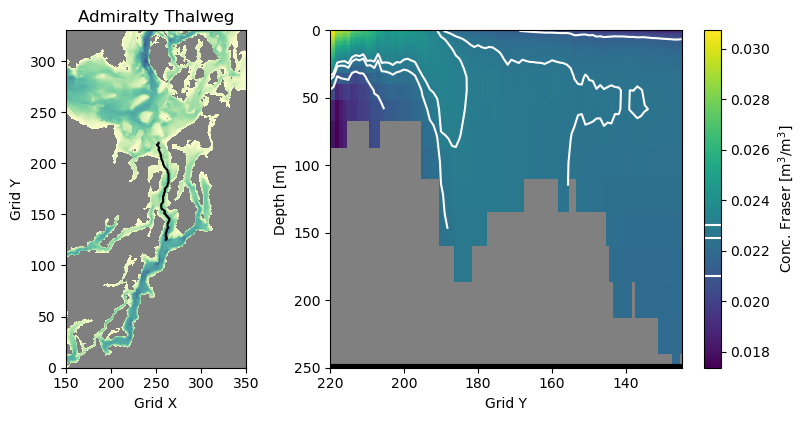

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1,2]})
fig.tight_layout(pad=1.2)

# cmap = mpl.colormaps['plasma']
# cmap = cm.amp
# fras_cont = [0.02, 0.022, 0.024, 0.026, 0.028, 0.03]
fras_cont = [0.021, 0.0225, 0.023]

cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

dim = conc_all_thal_ad.dim_0
# X = conc_all_thal_ad.gridX
X = conc_all_thal_ad.gridY
xmin = X.min()
xmax = X.max()
Y = conc_all_thal_ad.depth
Z = np.ma.masked_array(conc_all_thal_ad, mask=tmask_thal_ad)
colours = ax[1].pcolormesh(X, Y, Z, cmap=cmap, vmax=conc_all_thal_ad.max())
ax[1].set_ylim([250, 0])
ax[1].set_xlim([220, 125])
sum_vol_thal_ad = vol_all_thal_ad.sum().values/1000000
# ax[1].set_title('Sum: {} $*~10^6~m^3$'.format(str(sum_vol_thal_ad.round(1))))
ax[1].set_xlabel('Grid Y')
ax[1].plot([xmin-1, xmax], [249,249], color='k', linewidth=3)
ax[1].set_ylabel('Depth [m]')

cont1 = ax[1].contour(X, Y, Z, fras_cont, colors='white')
# ax[1].clabel(cont1, cont1.levels, fontsize=10)

cb = fig.colorbar(colours, ax=ax[1], label=r'Conc. Fraser [m$^3$/m$^3$]', orientation='vertical')
cb.add_lines(cont1)

mycmap = cm.deep
mycmap.set_bad('grey')

ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax[0].set_title('Admiralty Thalweg')
ax[0].set_xlim(150,350)
ax[0].set_ylim(0,330)
viz_tools.set_aspect(ax[0]);
ax[0].plot(x_thal_ad, y_thal_ad, color='k')
ax[0].set_xlabel('Grid X')
ax[0].set_ylabel('Grid Y')

Text(62.597222222222214, 0.5, 'Grid Y')

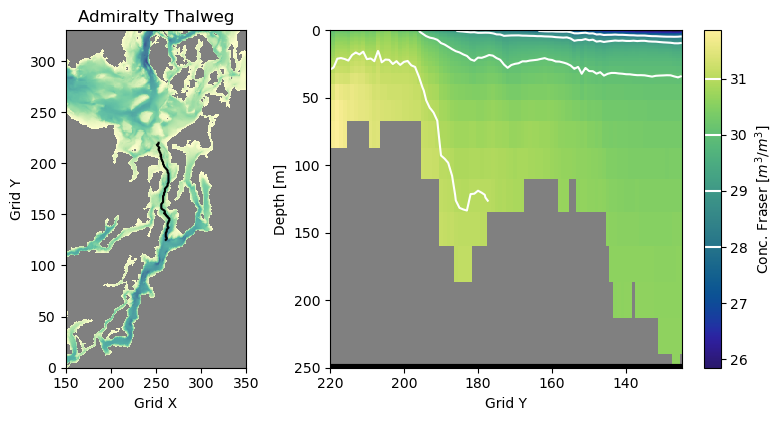

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1,2]})
fig.tight_layout(pad=1.2)

saline_cont = [28, 29, 30, 31]

cmap = cm.haline
cmap.set_bad('gray')

dim = phys_all_thal_ad['vosaline'].dim_0
X = phys_all_thal_ad['vosaline'].gridY
xmin = X.min()
xmax = X.max()
Y = phys_all_thal_ad['vosaline'].depth
Z = np.ma.masked_array(phys_all_thal_ad['vosaline'], mask=tmask_thal_ad)
colours = ax[1].pcolormesh(X, Y, Z, cmap=cmap, vmax=phys_all_thal_ad['vosaline'].max())
ax[1].set_ylim([250, 0])
ax[1].set_xlim([220, 125])
ax[1].set_xlabel('Grid Y')
ax[1].plot([xmin-1, xmax], [249,249], color='k', linewidth=3)
ax[1].set_ylabel('Depth [m]')

cont1 = ax[1].contour(X, Y, Z, saline_cont, colors='white')

cb = fig.colorbar(colours, ax=ax[1], label=r'Conc. Fraser [$m^3/m^3$]', orientation='vertical')
cb.add_lines(cont1)

mycmap = cm.deep
mycmap.set_bad('grey')

ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax[0].set_title('Admiralty Thalweg')
ax[0].set_xlim(150,350)
ax[0].set_ylim(0,330)
viz_tools.set_aspect(ax[0]);
ax[0].plot(x_thal_ad, y_thal_ad, color='k')
ax[0].set_xlabel('Grid X')
ax[0].set_ylabel('Grid Y')

Text(0.5, 14.722222222222216, 'Grid X')

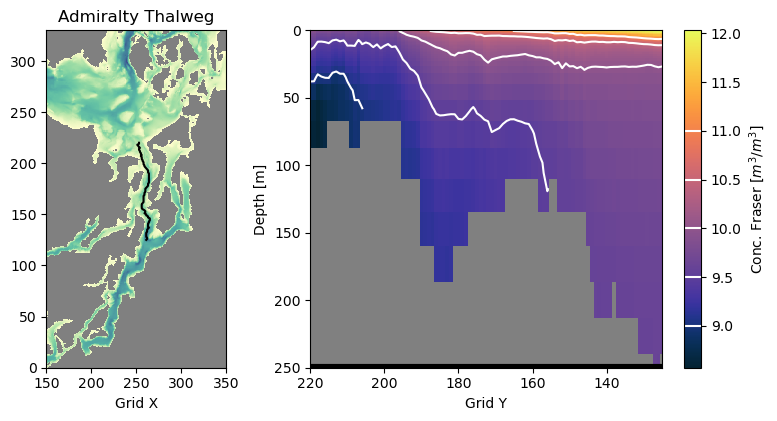

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1,2]})
fig.tight_layout(pad=1.2)

temp_cont = [9, 9.5, 10, 10.5, 11]

cmap = cm.thermal
cmap.set_bad('gray')

dim = phys_all_thal_ad['votemper'].dim_0
X = phys_all_thal_ad['votemper'].gridY
xmin = X.min()
xmax = X.max()
Y = phys_all_thal_ad['votemper'].depth
Z = np.ma.masked_array(phys_all_thal_ad['votemper'], mask=tmask_thal_ad)
colours = ax[1].pcolormesh(X, Y, Z, cmap=cmap, vmax=phys_all_thal_ad['votemper'].max())
ax[1].set_ylim([250, 0])
ax[1].set_xlim([220, 125])
ax[1].set_xlabel('Grid Y')
ax[1].plot([xmin-1, xmax], [249,249], color='k', linewidth=3)
ax[1].set_ylabel('Depth [m]')

cont1 = ax[1].contour(X, Y, Z, temp_cont, colors='white')

cb = fig.colorbar(colours, ax=ax[1], label=r'Conc. Fraser [$m^3/m^3$]', orientation='vertical')
cb.add_lines(cont1)

mycmap = cm.deep
mycmap.set_bad('grey')

ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax[0].set_title('Admiralty Thalweg')
ax[0].set_xlim(150,350)
ax[0].set_ylim(0,330)
viz_tools.set_aspect(ax[0]);
ax[0].plot(x_thal_ad, y_thal_ad, color='k')
ax[0].set_xlabel('Grid X')

Text(0.5, 14.722222222222216, 'Grid X')

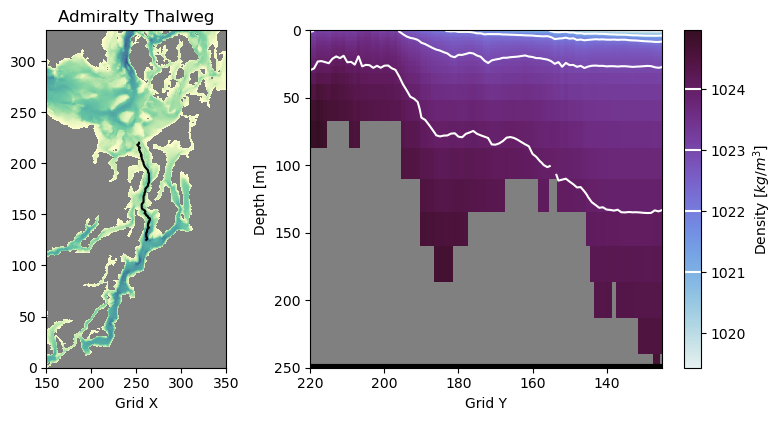

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1,2]})
fig.tight_layout(pad=1.2)

temp_cont = [1021, 1022, 1023, 1024]

cmap = cm.dense
cmap.set_bad('gray')

dim = phys_all_thal_ad['votemper'].dim_0
X = phys_all_thal_ad['votemper'].gridY
xmin = X.min()
xmax = X.max()
Y = phys_all_thal_ad['votemper'].depth

dens = gsw.density.rho(phys_all_thal_ad['vosaline'], phys_all_thal_ad['votemper'], np.tile(np.array(phys_all_thal_ad['votemper'].depth)[:, np.newaxis],len(X)))
Z = np.ma.masked_array(dens, mask=tmask_thal_ad)
colours = ax[1].pcolormesh(X, Y, Z, cmap=cmap, vmax=dens.max())
ax[1].set_ylim([250, 0])
ax[1].set_xlim([220, 125])
ax[1].set_xlabel('Grid Y')
ax[1].plot([xmin-1, xmax], [249,249], color='k', linewidth=3)
ax[1].set_ylabel('Depth [m]')

cont1 = ax[1].contour(X, Y, Z, temp_cont, colors='white')

cb = fig.colorbar(colours, ax=ax[1], label=r'Density [$kg/m^3$]', orientation='vertical')
cb.add_lines(cont1)

mycmap = cm.deep
mycmap.set_bad('grey')

ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax[0].set_title('Admiralty Thalweg')
ax[0].set_xlim(150,350)
ax[0].set_ylim(0,330)
viz_tools.set_aspect(ax[0]);
ax[0].plot(x_thal_ad, y_thal_ad, color='k')
ax[0].set_xlabel('Grid X')

# Two Years Compare

### High: 2021

In [23]:
conc_2021_thal_ad = vol_2021_thal_ad / volume_thal_ad

Text(62.597222222222214, 0.5, 'Grid Y')

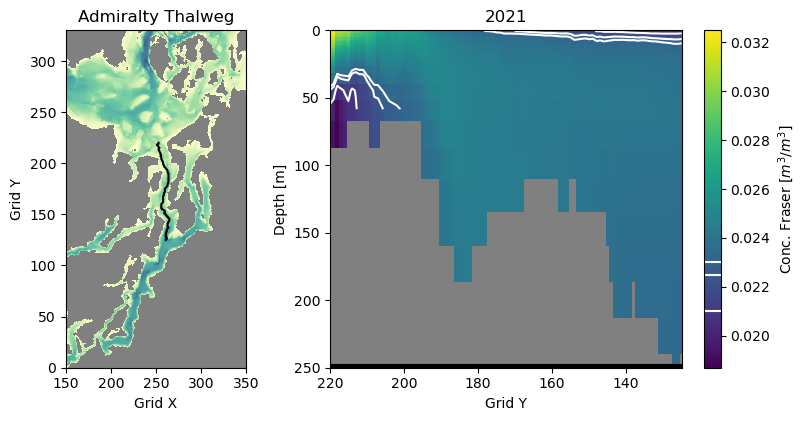

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1,2]})
fig.tight_layout(pad=1.2)

# cmap = mpl.colormaps['plasma']
# cmap = cm.amp
# fras_cont = [0.02, 0.022, 0.024, 0.026, 0.028, 0.03]
fras_cont = [0.021, 0.0225, 0.023]

cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

dim = conc_2021_thal_ad.dim_0
# X = conc_2021_thal_ad.gridX
X = conc_2021_thal_ad.gridY
xmin = X.min()
xmax = X.max()
Y = conc_2021_thal_ad.depth
Z = np.ma.masked_array(conc_2021_thal_ad, mask=tmask_thal_ad)
colours = ax[1].pcolormesh(X, Y, Z, cmap=cmap, vmax=conc_2021_thal_ad.max())
ax[1].set_ylim([250, 0])
ax[1].set_xlim([220, 125])
sum_vol_thal_ad = vol_2021_thal_ad.sum().values/1000000
# ax[1].set_title('Sum: {} $*~10^6~m^3$'.format(str(sum_vol_thal_ad.round(1))))
ax[1].set_xlabel('Grid Y')
ax[1].plot([xmin-1, xmax], [249,249], color='k', linewidth=3)
ax[1].set_ylabel('Depth [m]')
ax[1].set_title('2021')

cont1 = ax[1].contour(X, Y, Z, fras_cont, colors='white')
# ax[1].clabel(cont1, cont1.levels, fontsize=10)

cb = fig.colorbar(colours, ax=ax[1], label=r'Conc. Fraser [$m^3/m^3$]', orientation='vertical')
cb.add_lines(cont1)

mycmap = cm.deep
mycmap.set_bad('grey')

ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax[0].set_title('Admiralty Thalweg')
ax[0].set_xlim(150,350)
ax[0].set_ylim(0,330)
viz_tools.set_aspect(ax[0]);
ax[0].plot(x_thal_ad, y_thal_ad, color='k')
ax[0].set_xlabel('Grid X')
ax[0].set_ylabel('Grid Y')


### Low: 2023

In [25]:
conc_2023_thal_ad = vol_2023_thal_ad / volume_thal_ad

Text(62.597222222222214, 0.5, 'Grid Y')

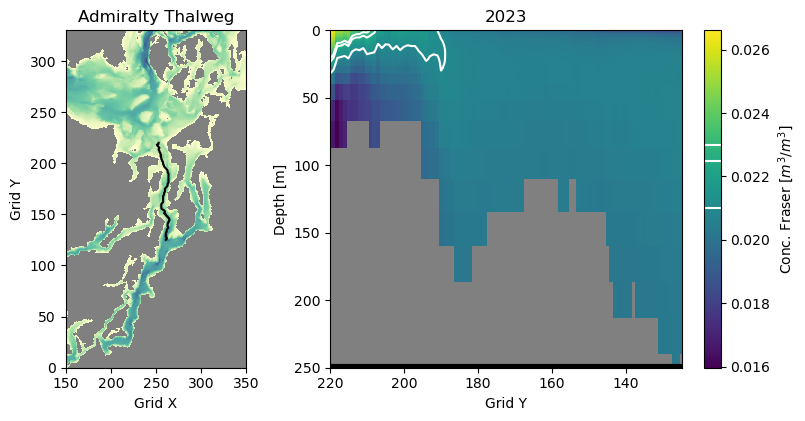

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1,2]})
fig.tight_layout(pad=1.2)

# cmap = mpl.colormaps['plasma']
# cmap = cm.amp
# fras_cont = [0.02, 0.022, 0.024, 0.026, 0.028, 0.03]
fras_cont = [0.021, 0.0225, 0.023]

cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

dim = conc_2023_thal_ad.dim_0
# X = conc_2023_thal_ad.gridX
X = conc_2023_thal_ad.gridY
xmin = X.min()
xmax = X.max()
Y = conc_2023_thal_ad.depth
Z = np.ma.masked_array(conc_2023_thal_ad, mask=tmask_thal_ad)
colours = ax[1].pcolormesh(X, Y, Z, cmap=cmap, vmax=conc_2023_thal_ad.max())
ax[1].set_ylim([250, 0])
ax[1].set_xlim([220, 125])
sum_vol_thal_ad = vol_2023_thal_ad.sum().values/1000000
# ax[1].set_title('Sum: {} $*~10^6~m^3$'.format(str(sum_vol_thal_ad.round(1))))
ax[1].set_xlabel('Grid Y')
ax[1].plot([xmin-1, xmax], [249,249], color='k', linewidth=3)
ax[1].set_ylabel('Depth [m]')
ax[1].set_title('2023')

cont1 = ax[1].contour(X, Y, Z, fras_cont, colors='white')
# ax[1].clabel(cont1, cont1.levels, fontsize=10)

cb = fig.colorbar(colours, ax=ax[1], label=r'Conc. Fraser [$m^3/m^3$]', orientation='vertical')
cb.add_lines(cont1)

mycmap = cm.deep
mycmap.set_bad('grey')

ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax[0].set_title('Admiralty Thalweg')
ax[0].set_xlim(150,350)
ax[0].set_ylim(0,330)
viz_tools.set_aspect(ax[0]);
ax[0].plot(x_thal_ad, y_thal_ad, color='k')
ax[0].set_xlabel('Grid X')
ax[0].set_ylabel('Grid Y')


## September

In [27]:
vol_2023_thal_ad_sept = vol_2023_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2023-09-15T00:00:00.000000000')
vol_2022_thal_ad_sept = vol_2022_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2022-09-15T00:00:00.000000000')
vol_2021_thal_ad_sept = vol_2021_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2021-09-15T00:00:00.000000000')
vol_2020_thal_ad_sept = vol_2020_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2020-09-15T00:00:00.000000000')
vol_2019_thal_ad_sept = vol_2019_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2019-09-15T00:00:00.000000000')
vol_all_thal_ad_sept = xr.concat([vol_2019_thal_ad_sept, vol_2020_thal_ad_sept, vol_2021_thal_ad_sept, vol_2022_thal_ad_sept, vol_2023_thal_ad_sept], dim='time').mean(dim='time')
tmask_thal_ad_sept = tmask.sel(x=xr.DataArray(x_thal_ad.astype(int)), y=xr.DataArray(y_thal_ad.astype(int)))
volume_thal_ad_sept = volume.sel(gridX=xr.DataArray(x_thal_ad.astype(int)), gridY=xr.DataArray(y_thal_ad.astype(int)))
conc_all_thal_ad_sept = vol_all_thal_ad_sept / volume_thal_ad_sept

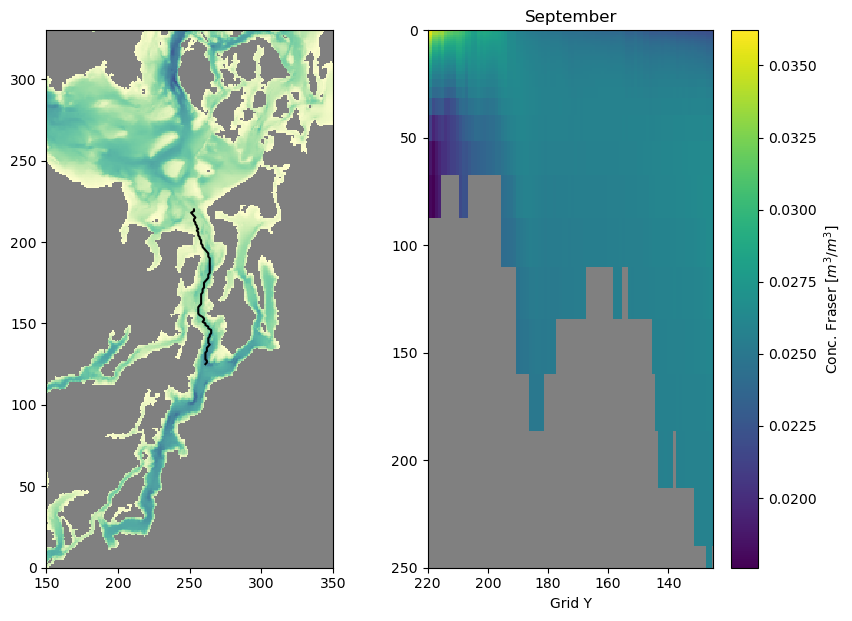

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 6))
fig.tight_layout(pad=1.2)

# cmap = mpl.colormaps['plasma']
# cmap = cm.amp
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fras_cont = [0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.03]

dim = conc_all_thal_ad_sept.dim_0
# X = conc_all_thal_ad_sept.gridX
X = conc_all_thal_ad_sept.gridY
xmin = X.min()
xmax = X.max()
Y = conc_all_thal_ad_sept.depth
Z = np.ma.masked_array(conc_all_thal_ad_sept, mask=tmask_thal_ad)
colours = ax[1].pcolormesh(X, Y, Z, cmap=cmap, vmax=conc_all_thal_ad_sept.max())
ax[1].set_ylim([250, 0])
ax[1].set_xlim([220, 125])
sum_vol_thal_ad_sept = vol_all_thal_ad_sept.sum().values/1000000
# ax[1].set_title('Sum: {} $*~10^6~m^3$'.format(str(sum_vol_thal_ad_sept.round(1))))
ax[1].set_title('September')
ax[1].set_xlabel('Grid Y')

cb = fig.colorbar(colours, ax=ax[1], label=r'Conc. Fraser [$m^3/m^3$]', orientation='vertical')
mycmap = cm.deep
mycmap.set_bad('grey')

ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax[0].set_xlim(150,350)
ax[0].set_ylim(0,330)
viz_tools.set_aspect(ax[0]);
ax[0].plot(x_thal_ad, y_thal_ad, color='k')

## May

In [29]:
vol_2023_thal_ad_may = vol_2023_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2023-05-15T12:00:00.000000000')
vol_2022_thal_ad_may = vol_2022_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2022-05-15T12:00:00.000000000')
vol_2021_thal_ad_may = vol_2021_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2021-05-15T12:00:00.000000000')
vol_2020_thal_ad_may = vol_2020_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2020-05-15T12:00:00.000000000')
vol_2019_thal_ad_may = vol_2019_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2019-05-15T12:00:00.000000000')
vol_all_thal_ad_may = xr.concat([vol_2019_thal_ad_may, vol_2020_thal_ad_may, vol_2021_thal_ad_may, vol_2022_thal_ad_may, vol_2023_thal_ad_may], dim='time').mean(dim='time')
tmask_thal_ad_may = tmask.sel(x=xr.DataArray(x_thal_ad.astype(int)), y=xr.DataArray(y_thal_ad.astype(int)))
volume_thal_ad_may = volume.sel(gridX=xr.DataArray(x_thal_ad.astype(int)), gridY=xr.DataArray(y_thal_ad.astype(int)))
conc_all_thal_ad_may = vol_all_thal_ad_may / volume_thal_ad_may

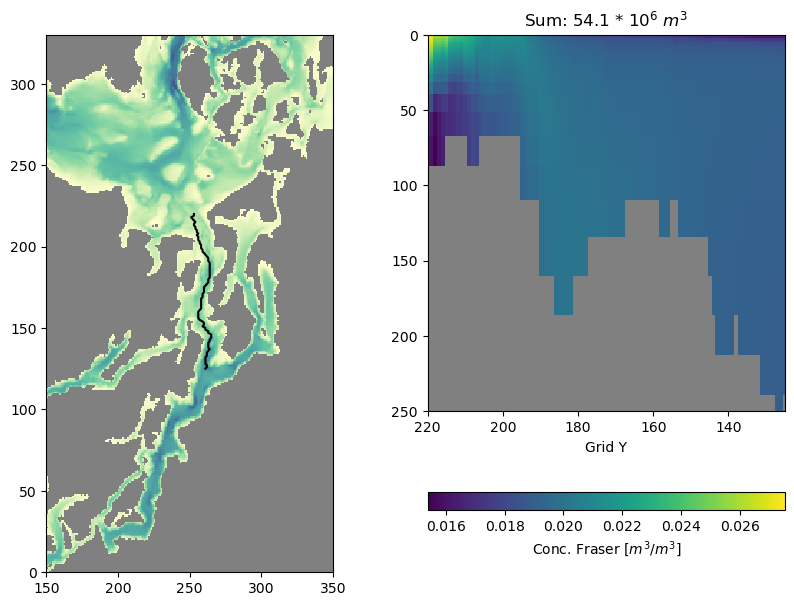

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 6))
fig.tight_layout(pad=1.2)

# cmap = mpl.colormaps['plasma']
# cmap = cm.amp
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

dim = conc_all_thal_ad_may.dim_0
# X = conc_all_thal_ad_may.gridX
X = conc_all_thal_ad_may.gridY
xmin = X.min()
xmax = X.max()
Y = conc_all_thal_ad_may.depth
Z = np.ma.masked_array(conc_all_thal_ad_may, mask=tmask_thal_ad)
colours = ax[1].pcolormesh(X, Y, Z, cmap=cmap, vmax=conc_all_thal_ad_may.max())
ax[1].set_ylim([250, 0])
ax[1].set_xlim([220, 125])
sum_vol_thal_ad_may = vol_all_thal_ad_may.sum().values/1000000
ax[1].set_title('Sum: {} $*~10^6~m^3$'.format(str(sum_vol_thal_ad_may.round(1))))
ax[1].set_xlabel('Grid Y')

cb = fig.colorbar(colours, ax=ax[1], label=r'Conc. Fraser [$m^3/m^3$]', orientation='horizontal')
mycmap = cm.deep
mycmap.set_bad('grey')

ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax[0].set_xlim(150,350)
ax[0].set_ylim(0,330)
viz_tools.set_aspect(ax[0]);
ax[0].plot(x_thal_ad, y_thal_ad, color='k')

In [31]:
vol_2023_mon['fraser_river']

<xarray.DataArray 'fraser_river' (time: 12, depth: 40, gridY: 898, gridX: 398)>
[171553920 values with dtype=float64]
Coordinates:
  * depth    (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * gridY    (gridY) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
  * gridX    (gridX) int64 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397
  * time     (time) datetime64[ns] 2023-01-15T12:00:00 ... 2023-12-15T12:00:00
Attributes:
    units:    m^3

## December

In [32]:
vol_2023_thal_ad_jan = vol_2023_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2023-01-15T12:00:00.000000000')
vol_2022_thal_ad_jan = vol_2022_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2022-01-15T12:00:00.000000000')
vol_2021_thal_ad_jan = vol_2021_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2021-01-15T12:00:00.000000000')
vol_2020_thal_ad_jan = vol_2020_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2020-01-15T12:00:00.000000000')
vol_2019_thal_ad_jan = vol_2019_mon['fraser_river'].sel(gridX=xr.DataArray(x_thal_ad), gridY=xr.DataArray(y_thal_ad), time='2019-01-15T12:00:00.000000000')
vol_all_thal_ad_jan = xr.concat([vol_2019_thal_ad_jan, vol_2020_thal_ad_jan, vol_2021_thal_ad_jan, vol_2022_thal_ad_jan, vol_2023_thal_ad_jan], dim='time').mean(dim='time')
tmask_thal_ad_jan = tmask.sel(x=xr.DataArray(x_thal_ad.astype(int)), y=xr.DataArray(y_thal_ad.astype(int)))
volume_thal_ad_jan = volume.sel(gridX=xr.DataArray(x_thal_ad.astype(int)), gridY=xr.DataArray(y_thal_ad.astype(int)))
conc_all_thal_ad_jan = vol_all_thal_ad_jan / volume_thal_ad_jan

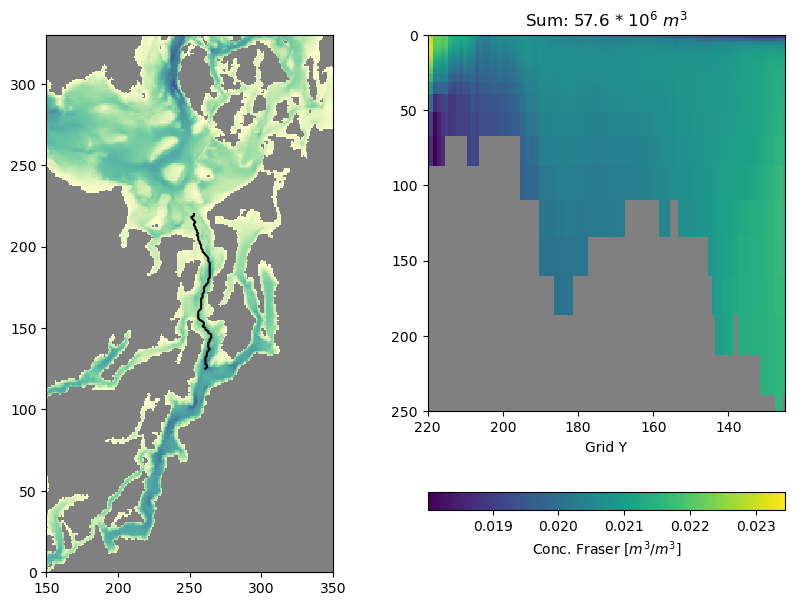

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 6))
fig.tight_layout(pad=1.2)

# cmap = mpl.colormaps['plasma']
# cmap = cm.amp
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

dim = conc_all_thal_ad_jan.dim_0
# X = conc_all_thal_ad_jan.gridX
X = conc_all_thal_ad_jan.gridY
xmin = X.min()
xmax = X.max()
Y = conc_all_thal_ad_jan.depth
Z = np.ma.masked_array(conc_all_thal_ad_jan, mask=tmask_thal_ad)
colours = ax[1].pcolormesh(X, Y, Z, cmap=cmap, vmax=conc_all_thal_ad_jan.max())
ax[1].set_ylim([250, 0])
ax[1].set_xlim([220, 125])
sum_vol_thal_ad_jan = vol_all_thal_ad_jan.sum().values/1000000
ax[1].set_title('Sum: {} $*~10^6~m^3$'.format(str(sum_vol_thal_ad_jan.round(1))))
ax[1].set_xlabel('Grid Y')

cb = fig.colorbar(colours, ax=ax[1], label=r'Conc. Fraser [$m^3/m^3$]', orientation='horizontal')
mycmap = cm.deep
mycmap.set_bad('grey')

ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax[0].set_xlim(150,350)
ax[0].set_ylim(0,330)
viz_tools.set_aspect(ax[0]);
ax[0].plot(x_thal_ad, y_thal_ad, color='k')

## All Together

Text(0.5, 3.722222222222216, 'Grid Y')

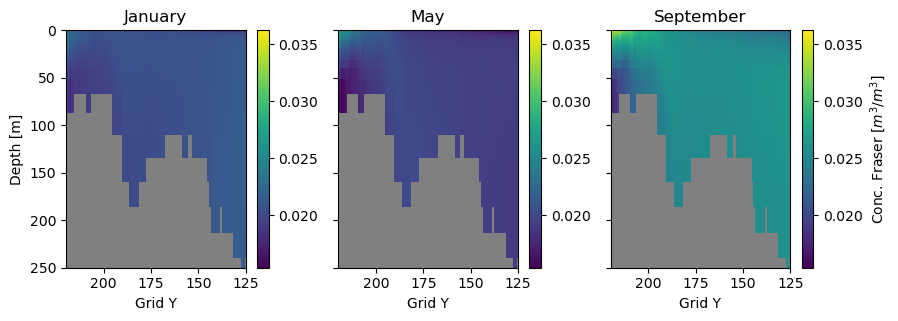

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(8.5, 3), sharey=True)
fig.tight_layout(pad=1.2)

maxed = np.array([conc_all_thal_ad_jan.max(), conc_all_thal_ad_may.max(), conc_all_thal_ad_sept.max()]).max()
mined = np.array([conc_all_thal_ad_jan.min(), conc_all_thal_ad_may.min(), conc_all_thal_ad_sept.min()]).min()
fras_cont = [0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.03]

cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

## January
dim = conc_all_thal_ad_jan.dim_0
X = conc_all_thal_ad_jan.gridY
xmin = X.min()
xmax = X.max()
Y = conc_all_thal_ad_jan.depth
Z = np.ma.masked_array(conc_all_thal_ad_jan, mask=tmask_thal_ad)
colours = ax[0].pcolormesh(X, Y, Z, cmap=cmap, vmax=maxed, vmin=mined)
cb1 = fig.colorbar(colours, ax=ax[0], orientation='vertical')
ax[0].set_ylim([250, 0])
ax[0].set_xlim([220, 125])
sum_vol_thal_ad_jan = vol_all_thal_ad_jan.sum().values/1000000
# ax[0].set_title('Sum: {} $*~10^6~m^3$'.format(str(sum_vol_thal_ad_jan.round(1))))
ax[0].set_title('January')
ax[0].set_xlabel('Grid Y')
ax[0].set_ylabel('Depth [m]')

#cont1 = ax[0].contour(X, Y, Z, fras_cont, colors='white')
#ax[0].clabel(cont1, cont1.levels, fontsize=10)

## May
dim = conc_all_thal_ad_may.dim_0
X = conc_all_thal_ad_may.gridY
xmin = X.min()
xmax = X.max()
Y = conc_all_thal_ad_may.depth
Z = np.ma.masked_array(conc_all_thal_ad_may, mask=tmask_thal_ad)
colours = ax[1].pcolormesh(X, Y, Z, cmap=cmap, vmax=maxed, vmin=mined)
cb2 = fig.colorbar(colours, ax=ax[1], orientation='vertical')
ax[1].set_ylim([250, 0])
ax[1].set_xlim([220, 125])
sum_vol_thal_ad_may = vol_all_thal_ad_may.sum().values/1000000
# ax[1].set_title('Sum: {} $*~10^6~m^3$'.format(str(sum_vol_thal_ad_may.round(1))))
ax[1].set_title('May')
ax[1].set_xlabel('Grid Y')
# ax[1].set_ylabel('Depth [m]')

#cont1 = ax[1].contour(X, Y, Z, fras_cont, colors='white')
#ax[1].clabel(cont1, cont1.levels, fontsize=10)

## September
dim = conc_all_thal_ad_sept.dim_0
X = conc_all_thal_ad_sept.gridY
xmin = X.min()
xmax = X.max()
Y = conc_all_thal_ad_sept.depth
Z = np.ma.masked_array(conc_all_thal_ad_sept, mask=tmask_thal_ad)
colours = ax[2].pcolormesh(X, Y, Z, cmap=cmap, vmax=maxed, vmin=mined)
cb3 = fig.colorbar(colours, ax=ax[2], label=r'Conc. Fraser [$m^3/m^3$]', orientation='vertical')
ax[2].set_ylim([250, 0])
ax[2].set_xlim([220, 125])
sum_vol_thal_ad_sept = vol_all_thal_ad_sept.sum().values/1000000
# ax[2].set_title('Sum: {} $*~10^6~m^3$'.format(str(sum_vol_thal_ad_sept.round(1))))
ax[2].set_title('September')
ax[2].set_xlabel('Grid Y')
# ax[2].set_ylabel('Depth [m]')

#cont1 = ax[2].contour(X, Y, Z, fras_cont, colors='white')
#ax[2].clabel(cont1, cont1.levels, fontsize=10)

# cb = fig.colorbar(colours, ax=ax[:], label=r'Conc. Fraser [$m^3/m^3$]', orientation='vertical')
# cb.add_lines(cont1)